In [1]:
# Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 6)
np.random.seed(42)  # Set random seed for reproducibility

In [2]:
# Load and Preprocess Data
# Parkinson's data: only motor UPDRS
parkinsons_df = pd.read_csv('data/parkinsons_updrs.data').drop('subject#', axis=1)
features_park = [col for col in parkinsons_df.columns if col not in ['motor_UPDRS', 'total_UPDRS']]

# WDBC data  
wdbc_df = pd.read_csv('data/wdbc.data', header=None)
column_names = ['id', 'diagnosis'] + [f'feature_{i}' for i in range(1, 31)]
wdbc_df.columns = column_names
wdbc_df = wdbc_df.drop('id', axis=1)
wdbc_df['diagnosis'] = LabelEncoder().fit_transform(wdbc_df['diagnosis'])  # M=1, B=0

print("Data loaded and preprocessed")

Data loaded and preprocessed


In [3]:
# Prepare 80/20 Split with Normalization
# Parkinson's data: only motor UPDRS
X_park = parkinsons_df[features_park]
y_park = parkinsons_df['motor_UPDRS']  # Only motor UPDRS

X_park_train, X_park_test, y_park_train, y_park_test = train_test_split(
    X_park, y_park, test_size=0.2, random_state=42)

scaler_park = StandardScaler()
X_park_train_scaled = scaler_park.fit_transform(X_park_train)
X_park_test_scaled = scaler_park.transform(X_park_test)

# Convert to numpy arrays to avoid pandas indexing issues
y_park_train = y_park_train.values
y_park_test = y_park_test.values

# WDBC data preparation
X_wdbc = wdbc_df.drop('diagnosis', axis=1)
y_wdbc = wdbc_df['diagnosis']

X_wdbc_train, X_wdbc_test, y_wdbc_train, y_wdbc_test = train_test_split(
    X_wdbc, y_wdbc, test_size=0.2, random_state=42, stratify=y_wdbc)

scaler_wdbc = StandardScaler()
X_wdbc_train_scaled = scaler_wdbc.fit_transform(X_wdbc_train)
X_wdbc_test_scaled = scaler_wdbc.transform(X_wdbc_test)

# Convert to numpy arrays
y_wdbc_train = y_wdbc_train.values
y_wdbc_test = y_wdbc_test.values

print("80/20 split completed with feature normalization")

80/20 split completed with feature normalization


In [4]:
# Import Fixed Models
from models import LinearRegression, LogisticRegression, GradientDescent, StochasticGradientDescent

# Linear Regression (Analytical)
print("=== Linear Regression (Analytical) ===")
lr_motor = LinearRegression().fit_analytical(X_park_train_scaled, y_park_train)

motor_pred_train = lr_motor.predict(X_park_train_scaled)
motor_pred_test = lr_motor.predict(X_park_test_scaled)

print(f"Motor UPDRS - Train R^2: {r2_score(y_park_train, motor_pred_train):.4f}, Test R^2: {r2_score(y_park_test, motor_pred_test):.4f}")

# Logistic Regression - Full Batch
print("\n=== Logistic Regression (Full Batch) ===")
gd_optimizer = GradientDescent(lr=0.1, max_iters=1000)
logistic_model = LogisticRegression().fit(X_wdbc_train_scaled, y_wdbc_train, gd_optimizer)

wdbc_pred_train = logistic_model.predict(X_wdbc_train_scaled)
wdbc_pred_test = logistic_model.predict(X_wdbc_test_scaled)

print(f"WDBC - Train Accuracy: {accuracy_score(y_wdbc_train, wdbc_pred_train):.4f}")
print(f"WDBC - Test Accuracy: {accuracy_score(y_wdbc_test, wdbc_pred_test):.4f}")

=== Linear Regression (Analytical) ===
Motor UPDRS - Train R^2: 0.1635, Test R^2: 0.1224

=== Logistic Regression (Full Batch) ===
WDBC - Train Accuracy: 0.9846
WDBC - Test Accuracy: 0.9825


In [5]:
# Feature Weights Analysis
print("=== Feature Weights ===")

print("\nLinear Regression - Motor UPDRS (Top 10 features):")
motor_weights = pd.DataFrame({
    'feature': features_park + ['bias'],
    'weight': lr_motor.weights
}).sort_values('weight', key=abs, ascending=False)

print(motor_weights.head(10))

print("\nLogistic Regression (Top 10 features):")
logistic_weights = pd.DataFrame({
    'feature': [f'feature_{i}' for i in range(1, 31)] + ['bias'],
    'weight': logistic_model.weights
}).sort_values('weight', key=abs, ascending=False)

print(logistic_weights.head(10))

=== Feature Weights ===

Linear Regression - Motor UPDRS (Top 10 features):
          feature      weight
10   Shimmer:APQ3 -195.801716
13    Shimmer:DDA  193.730892
7      Jitter:DDP   69.374942
5      Jitter:RAP  -67.543421
19           bias   21.332631
8         Shimmer    2.505234
4     Jitter(Abs)   -2.352083
15            HNR   -1.937479
12  Shimmer:APQ11    1.818734
17            DFA   -1.752000

Logistic Regression (Top 10 features):
       feature    weight
21  feature_22  1.063875
10  feature_11  0.877678
20  feature_21  0.832273
23  feature_24  0.798641
28  feature_29  0.788057
22  feature_23  0.741399
7    feature_8  0.730721
1    feature_2  0.716382
27  feature_28  0.702748
13  feature_14  0.685683


In [6]:
# Training Size Effect Analysis
def evaluate_training_size(X, y, model_type, sizes=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], n_runs=5):
    train_scores, test_scores = [], []
    
    for size in sizes:
        train_size_scores, test_size_scores = [], []
        
        for run in range(n_runs):
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, random_state=run)
            
            # Convert to numpy arrays
            y_train = y_train.values if hasattr(y_train, 'values') else y_train
            y_test = y_test.values if hasattr(y_test, 'values') else y_test
            
            if model_type == 'linear':
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                
                model = LinearRegression().fit_analytical(X_train_scaled, y_train)
                train_pred = model.predict(X_train_scaled)
                test_pred = model.predict(X_test_scaled)
                
                train_score = r2_score(y_train, train_pred)
                test_score = r2_score(y_test, test_pred)
                
            else:  # logistic
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                
                model = LogisticRegression().fit(X_train_scaled, y_train, GradientDescent(lr=0.1, max_iters=500))
                train_pred = model.predict(X_train_scaled)
                test_pred = model.predict(X_test_scaled)
                
                train_score = accuracy_score(y_train, train_pred)
                test_score = accuracy_score(y_test, test_pred)
            
            train_size_scores.append(train_score)
            test_size_scores.append(test_score)
        
        train_scores.append((np.mean(train_size_scores), np.std(train_size_scores)))
        test_scores.append((np.mean(test_size_scores), np.std(test_size_scores)))
    
    return sizes, train_scores, test_scores

# Linear regression: motor UPDRS
sizes, motor_train_scores, motor_test_scores = evaluate_training_size(X_park, y_park, 'linear')

# Logistic regression
sizes, wdbc_train_scores, wdbc_test_scores = evaluate_training_size(X_wdbc, y_wdbc, 'logistic')

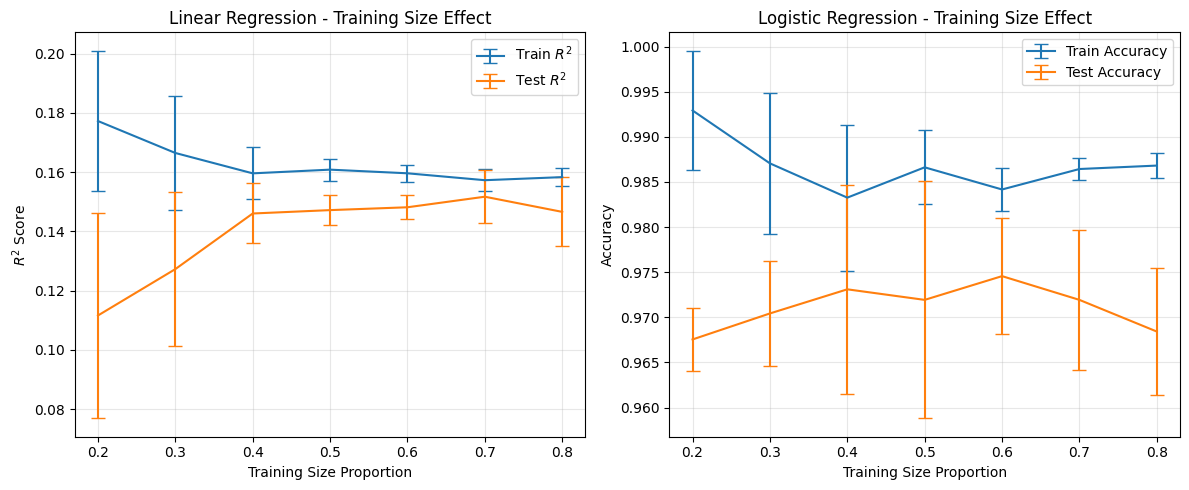

In [7]:
# Plot Training Size Effect
plt.figure(figsize=(12, 5))

# Linear regression plot
plt.subplot(1, 2, 1)
train_means = [score[0] for score in motor_train_scores]
train_stds = [score[1] for score in motor_train_scores]
test_means = [score[0] for score in motor_test_scores]
test_stds = [score[1] for score in motor_test_scores]

plt.errorbar(sizes, train_means, yerr=train_stds, label='Train $R^{2}$', capsize=5)
plt.errorbar(sizes, test_means, yerr=test_stds, label='Test $R^{2}$', capsize=5)
plt.xlabel('Training Size Proportion')
plt.ylabel('$R^{2}$ Score')
plt.title('Linear Regression - Training Size Effect')
plt.legend()
plt.grid(True, alpha=0.3)

# Logistic regression plot
plt.subplot(1, 2, 2)
train_means = [score[0] for score in wdbc_train_scores]
train_stds = [score[1] for score in wdbc_train_scores]
test_means = [score[0] for score in wdbc_test_scores]
test_stds = [score[1] for score in wdbc_test_scores]

plt.errorbar(sizes, train_means, yerr=train_stds, label='Train Accuracy', capsize=5)
plt.errorbar(sizes, test_means, yerr=test_stds, label='Test Accuracy', capsize=5)
plt.xlabel('Training Size Proportion')
plt.ylabel('Accuracy')
plt.title('Logistic Regression - Training Size Effect')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/training_size_effect.png', dpi=300, bbox_inches='tight')
plt.show()

Testing batch size: 8
Testing batch size: 16
Testing batch size: 32
Testing batch size: 64
Testing batch size: 128
Testing batch size: full


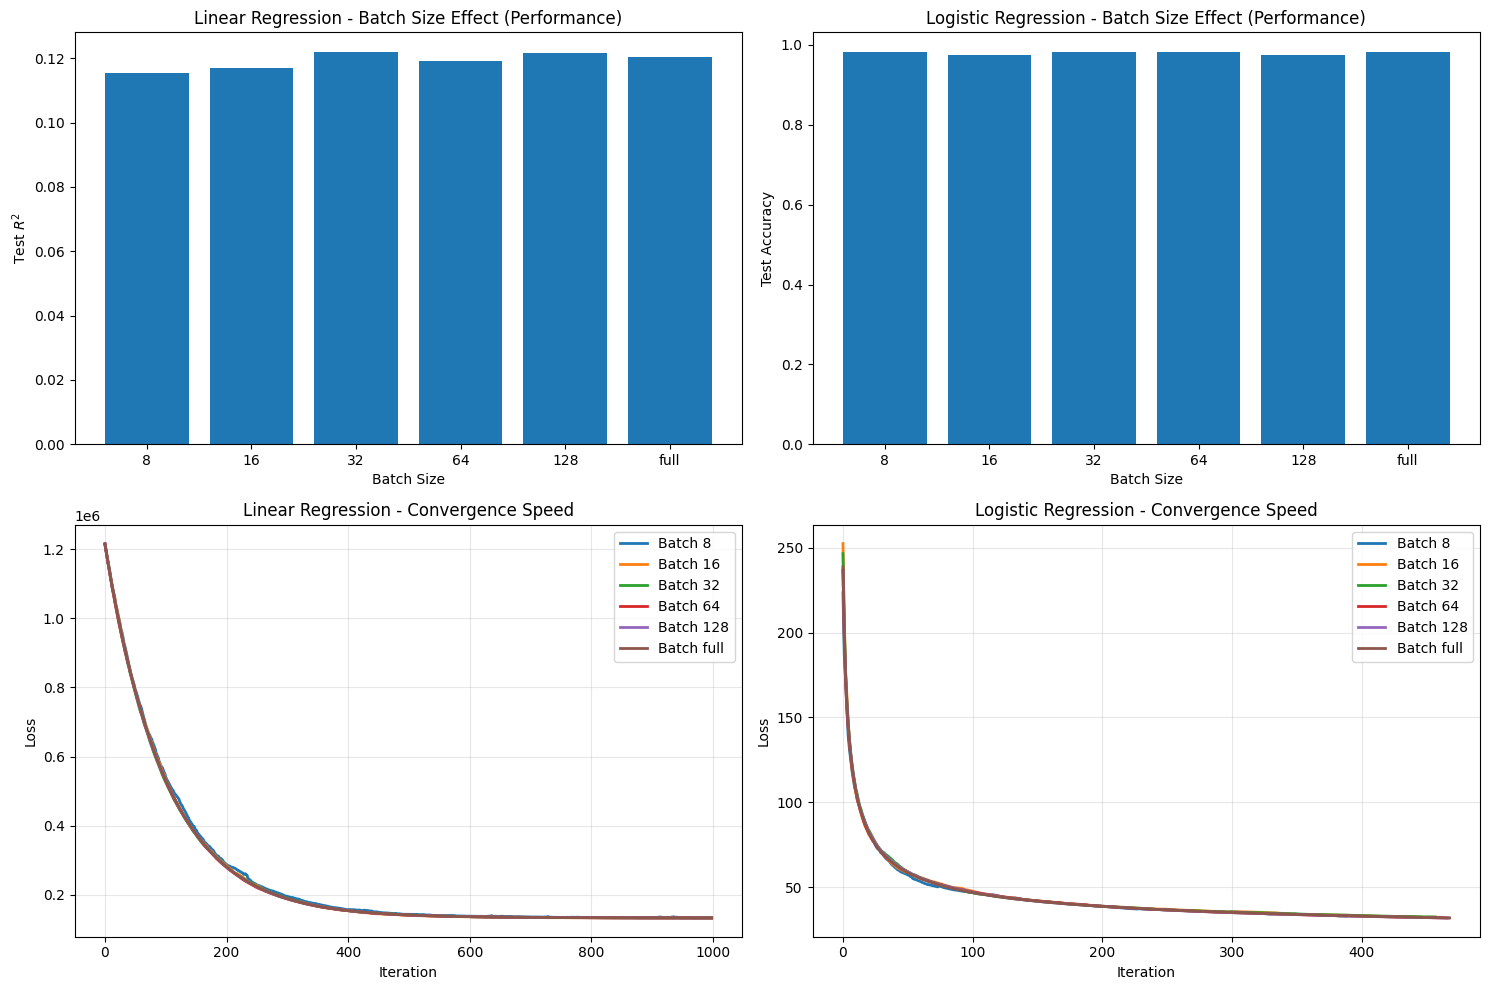

In [8]:
# Mini-batch Size Comparison with Convergence Plots
batch_sizes = [8, 16, 32, 64, 128, 'full']
linear_results, logistic_results = [], []
linear_loss_histories, logistic_loss_histories = [], []

for batch_size in batch_sizes:
    print(f"Testing batch size: {batch_size}")
    
    # Linear regression with mini-batch
    if batch_size == 'full':
        optimizer = GradientDescent(lr=0.01, max_iters=1000, record_loss=True)
    else:
        optimizer = StochasticGradientDescent(lr=0.01, max_iters=1000, batch_size=batch_size, record_loss=True)
    
    model = LinearRegression()
    model.fit_gradient_descent(X_park_train_scaled, y_park_train, optimizer)
    pred_test = model.predict(X_park_test_scaled)
    test_r2 = r2_score(y_park_test, pred_test)
    linear_results.append(test_r2)
    linear_loss_histories.append(optimizer.loss_history if hasattr(optimizer, 'loss_history') else [])
    
    # Logistic regression with mini-batch
    if batch_size == 'full':
        optimizer = GradientDescent(lr=0.1, max_iters=1000, record_loss=True)
    else:
        optimizer = StochasticGradientDescent(lr=0.1, max_iters=1000, batch_size=batch_size, record_loss=True)
    
    model = LogisticRegression()
    model.fit(X_wdbc_train_scaled, y_wdbc_train, optimizer)
    pred_test = model.predict(X_wdbc_test_scaled)
    test_acc = accuracy_score(y_wdbc_test, pred_test)
    logistic_results.append(test_acc)
    logistic_loss_histories.append(optimizer.loss_history if hasattr(optimizer, 'loss_history') else [])

# Plot results - Performance
plt.figure(figsize=(15, 10))

# Performance plots
plt.subplot(2, 2, 1)
x_pos = range(len(batch_sizes))
plt.bar(x_pos, linear_results)
plt.xticks(x_pos, [str(bs) for bs in batch_sizes])
plt.xlabel('Batch Size')
plt.ylabel('Test $R^{2}$')
plt.title('Linear Regression - Batch Size Effect (Performance)')

plt.subplot(2, 2, 2)
plt.bar(x_pos, logistic_results)
plt.xticks(x_pos, [str(bs) for bs in batch_sizes])
plt.xlabel('Batch Size')
plt.ylabel('Test Accuracy')
plt.title('Logistic Regression - Batch Size Effect (Performance)')

# Convergence plots
plt.subplot(2, 2, 3)
for i, batch_size in enumerate(batch_sizes):
    if linear_loss_histories[i]:
        plt.plot(range(len(linear_loss_histories[i])), linear_loss_histories[i], 
                label=f'Batch {batch_size}', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Linear Regression - Convergence Speed')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
for i, batch_size in enumerate(batch_sizes):
    if logistic_loss_histories[i]:
        plt.plot(range(len(logistic_loss_histories[i])), logistic_loss_histories[i], 
                label=f'Batch {batch_size}', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Logistic Regression - Convergence Speed')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/batch_size_effect_with_convergence.png', dpi=300, bbox_inches='tight')
plt.show()

Testing learning rate: 0.001
Testing learning rate: 0.01
Testing learning rate: 0.1


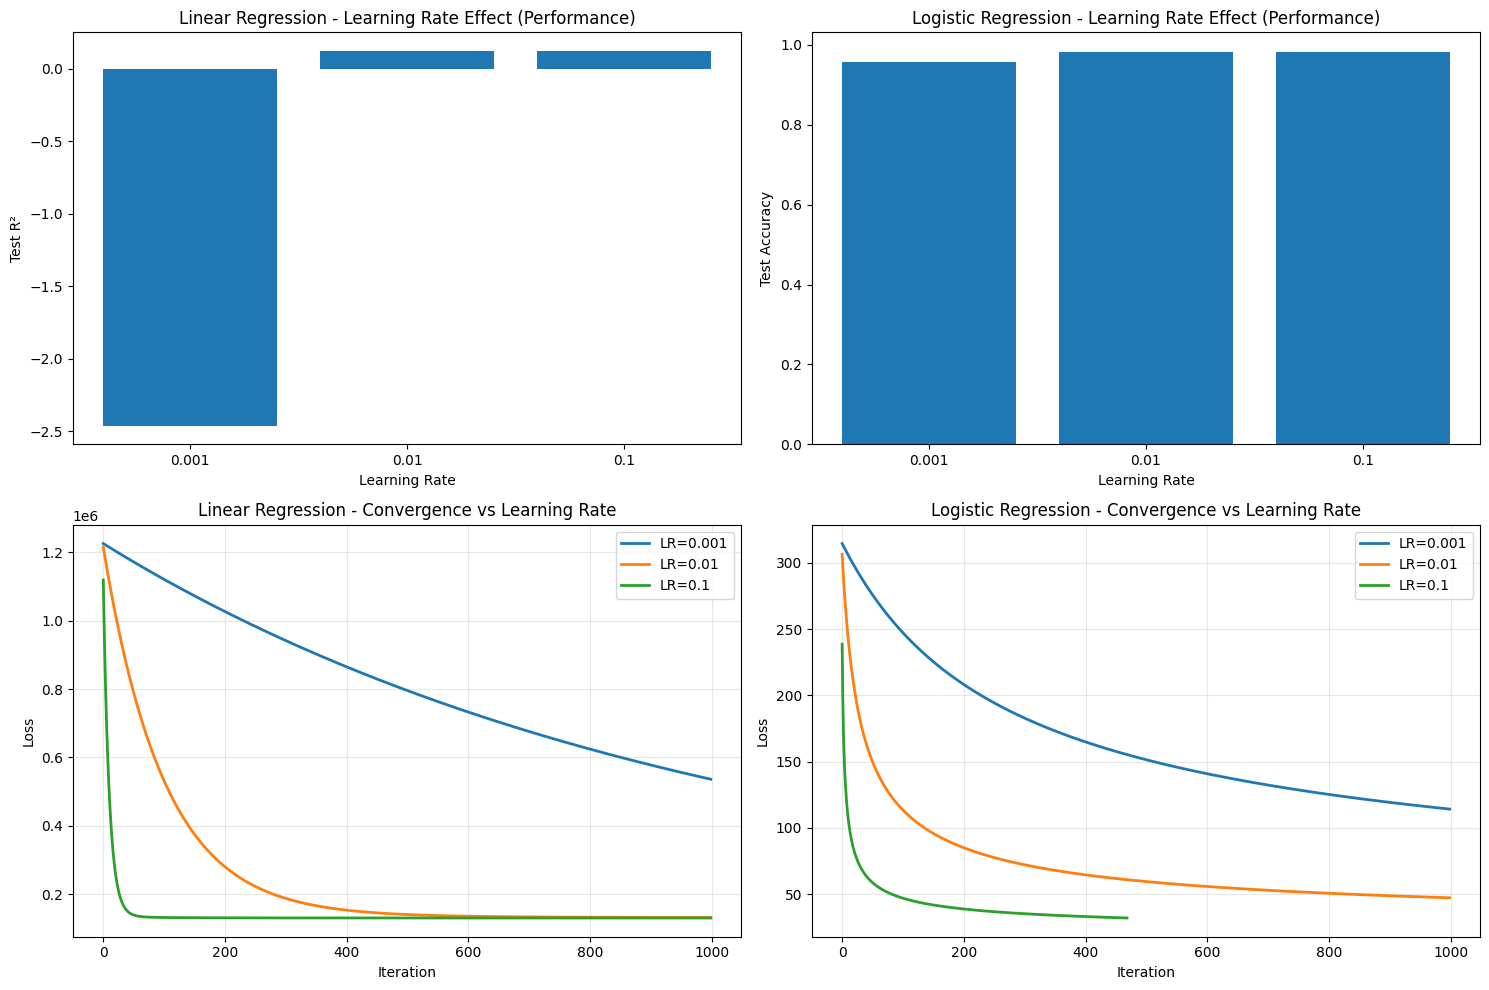

In [9]:
# Learning Rate Comparison with Convergence Plots
learning_rates = [0.001, 0.01, 0.1]
linear_lr_results, logistic_lr_results = [], []
linear_lr_loss_histories, logistic_lr_loss_histories = [], []

for lr in learning_rates:
    print(f"Testing learning rate: {lr}")
    
    # Linear regression
    optimizer = GradientDescent(lr=lr, max_iters=1000, record_loss=True)
    model = LinearRegression()
    model.fit_gradient_descent(X_park_train_scaled, y_park_train, optimizer)
    pred_test = model.predict(X_park_test_scaled)
    test_r2 = r2_score(y_park_test, pred_test)
    linear_lr_results.append(test_r2)
    linear_lr_loss_histories.append(optimizer.loss_history)
    
    # Logistic regression
    optimizer = GradientDescent(lr=lr, max_iters=1000, record_loss=True)
    model = LogisticRegression()
    model.fit(X_wdbc_train_scaled, y_wdbc_train, optimizer)
    pred_test = model.predict(X_wdbc_test_scaled)
    test_acc = accuracy_score(y_wdbc_test, pred_test)
    logistic_lr_results.append(test_acc)
    logistic_lr_loss_histories.append(optimizer.loss_history)

# Plot results - Performance
plt.figure(figsize=(15, 10))

# Performance plots
plt.subplot(2, 2, 1)
plt.bar(range(len(learning_rates)), linear_lr_results)
plt.xticks(range(len(learning_rates)), learning_rates)
plt.xlabel('Learning Rate')
plt.ylabel('Test R²')
plt.title('Linear Regression - Learning Rate Effect (Performance)')

plt.subplot(2, 2, 2)
plt.bar(range(len(learning_rates)), logistic_lr_results)
plt.xticks(range(len(learning_rates)), learning_rates)
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy')
plt.title('Logistic Regression - Learning Rate Effect (Performance)')

# Convergence plots
plt.subplot(2, 2, 3)
for i, lr in enumerate(learning_rates):
    plt.plot(range(len(linear_lr_loss_histories[i])), linear_lr_loss_histories[i], 
            label=f'LR={lr}', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Linear Regression - Convergence vs Learning Rate')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
for i, lr in enumerate(learning_rates):
    plt.plot(range(len(logistic_lr_loss_histories[i])), logistic_lr_loss_histories[i], 
            label=f'LR={lr}', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Logistic Regression - Convergence vs Learning Rate')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/learning_rate_effect_with_convergence.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Analytical vs SGD Comparison
print("=== Analytical vs SGD Comparison ===")

# Analytical solution (already computed)
analytical_r2 = r2_score(y_park_test, motor_pred_test)

# SGD solution
sgd_optimizer = StochasticGradientDescent(lr=0.01, max_iters=1000, batch_size=32)
sgd_model = LinearRegression()
sgd_model.fit_gradient_descent(X_park_train_scaled, y_park_train, sgd_optimizer)
sgd_pred_test = sgd_model.predict(X_park_test_scaled)
sgd_r2 = r2_score(y_park_test, sgd_pred_test)

print(f"Analytical Solution R^2: {analytical_r2:.4f}")
print(f"SGD Solution R^2: {sgd_r2:.4f}")
print(f"Difference: {abs(analytical_r2 - sgd_r2):.4f}")

# Weight comparison
print("\nWeight Comparison (first 5 features):")
weight_comparison = pd.DataFrame({
    'Feature': features_park[:5],
    'Analytical': lr_motor.weights[:5],
    'SGD': sgd_model.weights[:5],
    'Difference': np.abs(lr_motor.weights[:5] - sgd_model.weights[:5])
})
print(weight_comparison)

=== Analytical vs SGD Comparison ===
Analytical Solution R^2: 0.1224
SGD Solution R^2: 0.1217
Difference: 0.0007

Weight Comparison (first 5 features):
       Feature  Analytical       SGD  Difference
0          age    1.723060  1.820403    0.097343
1          sex   -0.510686 -0.342030    0.168655
2    test_time    0.607038  0.518803    0.088235
3    Jitter(%)    0.528044  0.238248    0.289796
4  Jitter(Abs)   -2.352083 -1.077135    1.274948


In [11]:
# Final Results Summary
print("=== FINAL RESULTS SUMMARY ===")

print("\n1. Baseline Performance:")
print(f"Linear Regression (Motor UPDRS): Train R^2 = {r2_score(y_park_train, motor_pred_train):.4f}, Test R^2 = {r2_score(y_park_test, motor_pred_test):.4f}")
print(f"Logistic Regression: Train Acc = {accuracy_score(y_wdbc_train, wdbc_pred_train):.4f}, Test Acc = {accuracy_score(y_wdbc_test, wdbc_pred_test):.4f}")

print("\n2. Best Batch Size:")
best_linear_batch = batch_sizes[np.argmax(linear_results)]
best_logistic_batch = batch_sizes[np.argmax(logistic_results)]
print(f"Linear Regression: {best_linear_batch}")
print(f"Logistic Regression: {best_logistic_batch}")

print("\n3. Best Learning Rate:")
best_linear_lr = learning_rates[np.argmax(linear_lr_results)]
best_logistic_lr = learning_rates[np.argmax(logistic_lr_results)]
print(f"Linear Regression: {best_linear_lr}")
print(f"Logistic Regression: {best_logistic_lr}")

print("\n4. Analytical vs SGD:")
print(f"Analytical R^2: {analytical_r2:.4f}, SGD R^2: {sgd_r2:.4f}")

=== FINAL RESULTS SUMMARY ===

1. Baseline Performance:
Linear Regression (Motor UPDRS): Train R^2 = 0.1635, Test R^2 = 0.1224
Logistic Regression: Train Acc = 0.9846, Test Acc = 0.9825

2. Best Batch Size:
Linear Regression: 32
Logistic Regression: 8

3. Best Learning Rate:
Linear Regression: 0.01
Logistic Regression: 0.01

4. Analytical vs SGD:
Analytical R^2: 0.1224, SGD R^2: 0.1217
